In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py as hd
from tqdm import tqdm

In [3]:
## These functions from mmpapping.py in caiman cnmfe
def prepare_shape(mytuple):
    """ This promotes the elements inside a shape into np.uint64. It is intended to prevent overflows
        with some numpy operations that are sensitive to it, e.g. np.memmap """
    if not isinstance(mytuple, tuple):
        raise Exception("Internal error: prepare_shape() passed a non-tuple")
    return tuple(map(lambda x: np.uint64(x), mytuple))

def load_memmap(filename, mode='r'):
    """ Load a memory mapped file created by the function save_memmap
    Args:
        filename: str
            path of the file to be loaded
        mode: str
            One of 'r', 'r+', 'w+'. How to interact with files
    Returns:
        Yr:
            memory mapped variable
        dims: tuple
            frame dimensions
        T: int
            number of frames
    Raises:
        Exception "Unknown file extension"
    """
    if ('.mmap' in filename):
        # Strip path components and use CAIMAN_DATA/example_movies
        # TODO: Eventually get the code to save these in a different dir
        file_to_load = filename
        filename = os.path.split(filename)[-1]
        fpart = filename.split('_')[1:-1] # The filename encodes the structure of the map
        d1, d2, d3, T, order = int(fpart[-9]), int(fpart[-7]
                                                   ), int(fpart[-5]), int(fpart[-1]), fpart[-3]
        Yr = np.memmap(file_to_load, mode=mode, shape=prepare_shape((d1 * d2 * d3, T)), dtype=np.float32, order=order)
        return (Yr, (d1, d2), T) if d3 == 1 else (Yr, (d1, d2, d3), T)
    else:
        logging.error("Unknown extension for file " + str(filename))
        raise Exception('Unknown file extension (should be .mmap)')

In [11]:
# load memory mapped file
path_to_file = '/volumes/My_Passport/MiniscopeMovies/1_24_2019/GRIN_011_ACHf20/H10_M19_S59/TIFs/H10_M19_S59msCam9_rig__d1_480_d2_752_d3_1_order_C_frames_1000_.mmap'
memmap_output = load_memmap(path_to_file, mode='r')

FileNotFoundError: [Errno 2] No such file or directory: '/volumes/My_Passport/MiniscopeMovies/1_24_2019/GRIN_011_ACHf20/H10_M19_S59/TIFs/H10_M19_S59msCam9_rig__d1_480_d2_752_d3_1_order_C_frames_1000_.mmap'

In [5]:
np.shape(memmap_output[0])

(360960, 1000)

In [6]:
np.prod(memmap_output[1])

360960

In [7]:
memmap_output[1]

(480, 752)

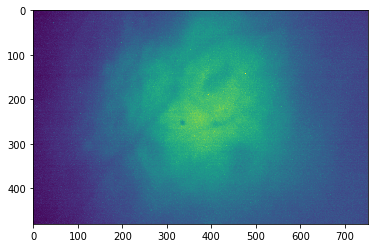

In [10]:
frame_n = memmap_output[0][:,1]
to_view = np.transpose(np.reshape(frame_n, (752, 480)))
plt.imshow(to_view)
plt.show()

In [ ]:
# create reshaped movie for viewing
hdf_file_name = path_to_file.rstrip('_.mmap')+'_resized.hdf5'
file = hd.File(hdf_file_name, "w")
movie = file.create_dataset('movie', shape = (int(memmap_output[2]), 480, 752), dtype = np.float32, chunks=True)

# movie is stored in memmap[0], array of dimension (pixels, frames)
# memmap[1] is movie dimensions in height x width
# memmap[2] is # of frames
for frame in tqdm(range(int(memmap_output[2]))):
    frame_n = memmap_output[0][:,frame]
    # reshape movie for viewing
    movie[frame] = np.transpose(np.reshape(frame_n, (752, 480)))
    
file.close()

In [ ]:
os.path.split(hdf_file_name)

In [ ]:
tuple(np.flip(memmap_output[1]))

In [ ]:
hdf_file_name = path_to_file.rstrip('_.mmap')+'_2d_forquest_cnmfe.hdf5'
file = hd.File(hdf_file_name, "w")
movie = file.create_dataset('movie', shape = (int(memmap_output[2]), np.prod(memmap_output[1])), dtype = np.float32, chunks=True)
file.attrs['folder'] = os.path.split(hdf_file_name)[0]
file.attrs['filename'] = hdf_file_name 
# movie is stored in memmap[0], array of dimension (pixels, frames)
# memmap[1] is movie dimensions in height x width
# memmap[2] is # of frames
# input for miniscoPy is transpose of caiman normcorr output
movie_array = np.array(memmap_output[0])
for frame in tqdm(range(int(np.shape(movie_array)[1]))):
    movie[frame] = movie_array[:,frame]

file['movie'].attrs['duration'] = int(memmap_output[2])
file['movie'].attrs['dims'] = tuple(np.flip(memmap_output[1]))
    
file.close()

In [ ]:
path_to_hdf5_file = '/volumes/My_Passport/MiniscopeMovies/GRIN_004_freely_moving/H16_M58_S18/motion_corrected.hdf5'
file = hd.File(path_to_hdf5_file, "r")

In [ ]:
len(memmap_output[0][:,1])

In [ ]:
np.shape(memmap_output[0])

In [ ]:
file['movie'][0]

In [ ]:
np.shape(np.array(memmap_output[0]))